In [7]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import ehtim as eh
import ehtim.const_def as ehc
from scipy import optimize
from skimage import transform
from scipy.signal import convolve2d
from tqdm import tqdm
import pickle
from scipy.optimize import curve_fit
import galaxy

In [8]:
galaxydataset = galaxy.GalaxyDataset()

--loading h5 file for Galaxy10 dataset...
Done--
--loading h5 file for eht sparse and dense {u,v,vis_re,vis_im} dataset...
Done--
using sparse grid visibility data..


In [9]:
data_root = '/home/zhouxinghui/git/VIC-DDPM-modified/data'
data_path = f'{data_root}/eht_grid_128FC_200im_Galaxy10_DECals_full.h5'
img_path = f'{data_root}/Galaxy10_DECals.h5'
u_sparse, v_sparse, vis_re_sparse, vis_im_sparse, u_dense, v_dense, vis_re_dense, vis_im_dense = galaxy.load_h5_uvvis(data_path)
img_data,_ = galaxy.load_h5(img_path)

--loading h5 file for eht sparse and dense {u,v,vis_re,vis_im} dataset...
Done--
--loading h5 file for Galaxy10 dataset...
Done--


In [10]:
mask = np.load("./data/mask.npy")
sort_indices = np.load("./data/sort_indices.npy")
uv_sparse = np.stack((u_sparse.flatten(), v_sparse.flatten()), axis=1)
uv_dense = np.stack((u_dense.flatten(), v_dense.flatten()), axis=1)
max_base = np.max(uv_sparse)
fourier_resolution = int(len(uv_dense)**(0.5))
uv_dense_scaled = np.rint((uv_dense+max_base) / max_base * (fourier_resolution-1)/2) / (fourier_resolution-1) - 0.5

psf = galaxy.to_img(mask[0], mask[1], uv_dense_scaled)
clean_beam, _ = galaxy.fit_clean_beam(psf)

In [11]:
idx = 0
def get_dirty(idx):
    vis_dense = np.stack((vis_re_dense[:,idx], vis_im_dense[:,idx]), axis=1)
    vis_real = vis_re_sparse[:,idx].astype(np.float32)
    vis_imag = vis_im_sparse[:,idx].astype(np.float32)
    vis_sparse = np.stack([vis_real, vis_imag], axis=1)
            
    sorted_vis = vis_dense[sort_indices]

    reshaped_vis = sorted_vis.reshape((128, 128, 2),order='C')
    vis_dense = reshaped_vis.transpose((2, 0, 1))
    vis_zf = vis_dense * mask
    image_dir = galaxy.to_img(vis_zf[0], vis_zf[1], uv_dense_scaled)
    scale_coeff = 1. / np.max(np.abs(image_dir))
    image_dir = image_dir * scale_coeff
    return image_dir

def get_target_and_gt(idx):
    gt = img_data[idx]
    gt = galaxy.rgb2gray(gt)
    gt = np.transpose(gt)
    gt = transform.resize(gt, (128, 128), anti_aliasing=True)
    target = convolve2d(gt, clean_beam, mode='same', boundary='wrap')
    return target, gt


def minmax(img):
    img = img*100
    img = (img - np.min(img)) / (np.max(img) - np.min(img) + 1e-12)
    return img

In [ ]:
import multiprocessing
# from tqdm import tqdm

dataset_length = 17736

def process_item(idx):
    dirty = get_dirty(idx)
    target, gt = get_target_and_gt(idx)
    
    dirty = minmax(dirty)
    target = minmax(target)
    gt = minmax(gt)
    
    one = {
        'x': dirty.astype(np.float32),
        'y': target.astype(np.float32),
        'gt': gt.astype(np.float32),  # 注意：这里假设 gt 是一个函数，如果 gt 是变量请调整
    }
    return one

if __name__ == "__main__":
    # 创建一个进程池，根据你的 CPU 核心数设置合适的进程数
    # num_processes = multiprocessing.cpu_count()  # 获取 CPU 核心数
    num_processes = 100
    pool = multiprocessing.Pool(processes=num_processes)

    # 使用 Pool 的 map 方法并行处理数据
    my_dataset = list(tqdm(pool.imap(process_item, range(dataset_length)), total=dataset_length))

    # 关闭进程池
    pool.close()
    pool.join()

    # 此时 my_dataset 包含了所有处理后的数据

In [ ]:
with open('/mnt/storage-ssd/zhouxinghui/AI_CLEAN_DATASET/dirty_scale_maxbaseline3.pkl', 'wb') as f:
    pickle.dump(my_dataset, f) 

In [12]:
psf = galaxy.to_img(mask[0], mask[1], uv_dense_scaled)
clean_beam, _ = galaxy.fit_clean_beam(psf)
target, gt = get_target_and_gt(0)
dirty = get_dirty(0)


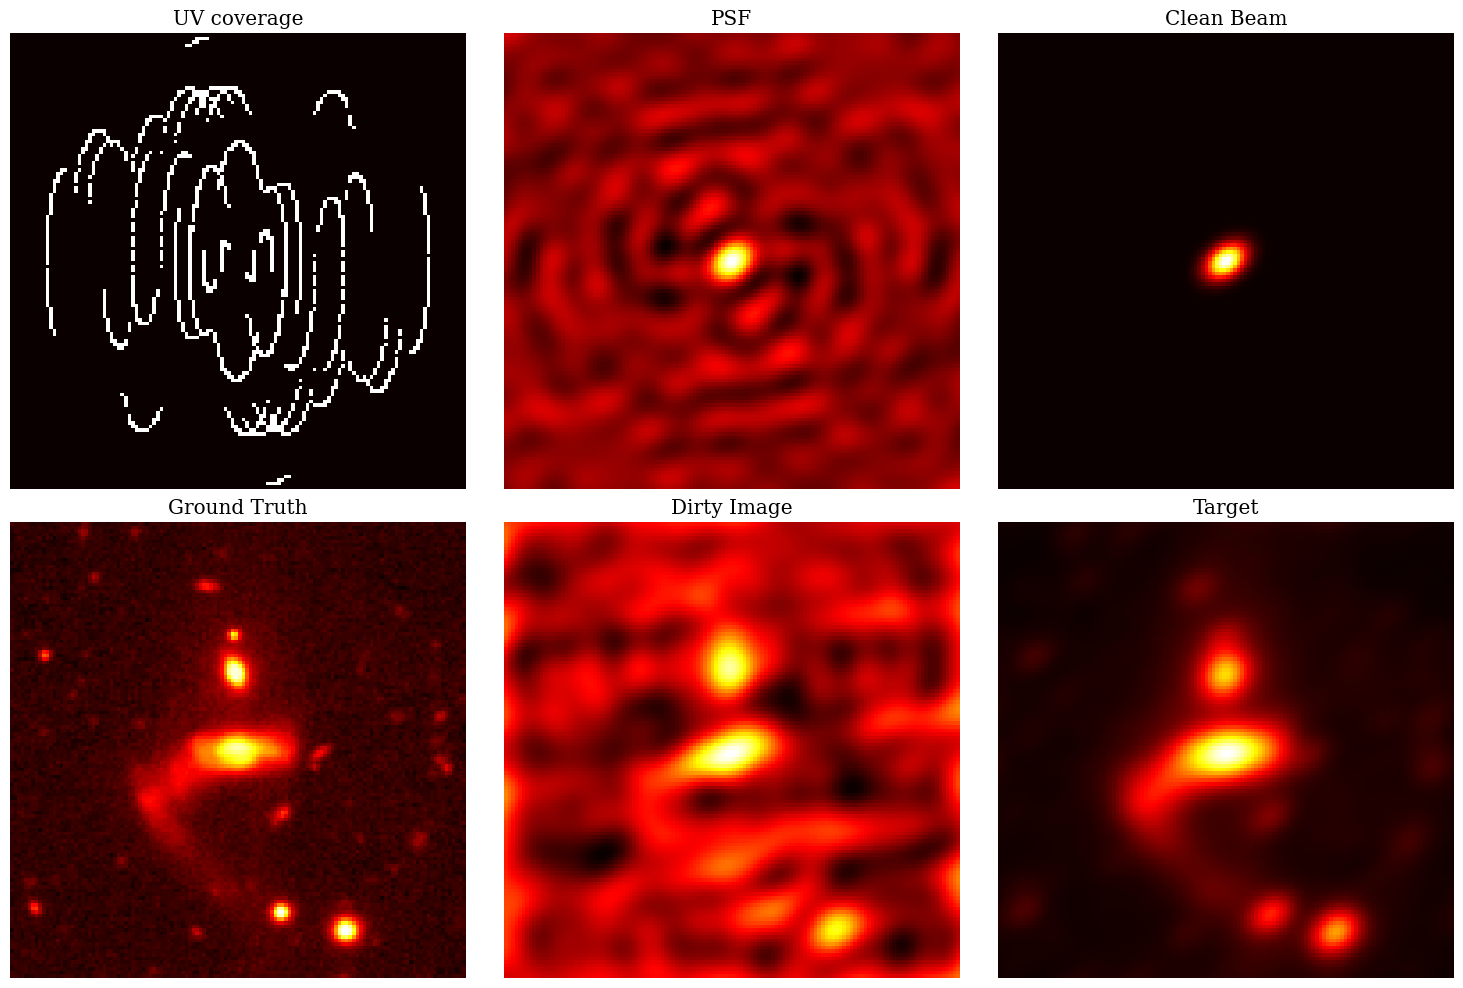

In [13]:
# 创建一个 2 行 3 列的子图布局
fig, axes = plt.subplots(2, 3, figsize=(15, 10))  # figsize 可以调整整个图的大小



# 第一行第一列
axes[0, 0].imshow(mask[1], cmap='hot')
axes[0, 0].axis('off')
axes[0, 0].set_title('UV coverage')  # 添加标题

# 第一行第二列
axes[0, 1].imshow(psf, cmap='hot')
axes[0, 1].axis('off')
axes[0, 1].set_title('PSF')  # 添加标题

# 第一行第三列
axes[0, 2].imshow(clean_beam, cmap='hot')
axes[0, 2].axis('off')
axes[0, 2].set_title('Clean Beam')  # 添加标题

# 第二行第一列
axes[1, 0].imshow(gt, cmap='hot')
axes[1, 0].axis('off')
axes[1, 0].set_title('Ground Truth')  # 添加标题

# 第二行第二列
axes[1, 1].imshow(dirty, cmap='hot')
axes[1, 1].axis('off')
axes[1, 1].set_title('Dirty Image')  # 添加标题

# 第二行第三列
axes[1, 2].imshow(target, cmap='hot')
axes[1, 2].axis('off')
axes[1, 2].set_title('Target')  # 添加标题

# 调整子图之间的间距
plt.tight_layout()

# 显示整个图形
plt.show()